In [17]:
import pylab as pl
import pandas as pd
import numpy as np
import csv
import json
import sys

%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Idea: 
Citi Bike riders in Brooklyn are younger than riders in Manhattan
### Hypotheses:
#####Null hypothesis: 
The average age of subscribers who start rides in Brooklyn stations is greater or the same as subscribers who start rides in Manhattan stations
#####Alternative hypothesis: 
The average of subscribers who start rides in Brooklyn stations is lower than that of subscribers who start rides in Manhattan stations

In [18]:
# Creating csv of station data from CitiBike json file

# jsonFile = open('stations.json','r')
# data = json.load(jsonFile)
# stations = data['stationBeanList']

# with open('stationsIdLatLong.csv','wb') as csvFile:
#     writer = csv.writer(csvFile)
#     for s in stations:
#         stationName = s['id']
#         stationLat = s['latitude']
#         stationLong = s['longitude']
#         row = [stationName,stationLat,stationLong]
#         writer.writerow(row)

In [20]:
# Reading in the Citi Bike trip data from Oct 2014
trips = pd.read_csv('/Users/hannahbkates/Desktop/201410-citibike-tripdata.csv')
trips.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1027,10/1/2014 00:00:27,10/1/2014 00:17:34,479,9 Ave & W 45 St,40.760193,-73.991255,540,Lexington Ave & E 26 St,40.741473,-73.983209,21376,Subscriber,1977,1
1,534,10/1/2014 00:00:36,10/1/2014 00:09:30,417,Barclay St & Church St,40.712912,-74.010202,417,Barclay St & Church St,40.712912,-74.010202,16086,Subscriber,1974,2
2,416,10/1/2014 00:00:42,10/1/2014 00:07:38,327,Vesey Pl & River Terrace,40.715338,-74.016584,415,Pearl St & Hanover Square,40.704718,-74.009260,16073,Subscriber,1990,1


In [21]:
# Reading in the csv of stations that have been joined with their borough (MH and BK only)
stations = pd.read_csv('/Users/hannahbkates/Desktop/stations.csv')
stations.head(5)

,X,Y,sid,lat,long,boro
0,-73.976323,40.683826,83,40.683826,-73.976323,BK
1,-73.978034,40.696089,119,40.696089,-73.978034,BK
2,-73.959282,40.686768,120,40.686768,-73.959282,BK
3,-73.993379,40.692395,143,40.692395,-73.993379,BK
4,-73.980689,40.698399,144,40.698399,-73.980689,BK


In [22]:
# Subsetting the trips data to only look at Subscribers and people with reasonable birth years
trips = trips[(trips['usertype']=='Subscriber')&(trips['birth year']>1925)]
trips['sid'] = trips['start station id']
trips['age'] = 2015-trips['birth year']

# Calculating the median of all values by sid
stations_med_age = trips.groupby('sid', as_index=False).agg(median)

type(stations_med_age)
stations_med_age.head(10)

,sid,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age
0,72,807.0,72,40.767272,-73.993929,450,40.752554,-73.992390,18003.0,1977,1,38
1,79,561.0,79,40.719116,-74.006667,347,40.722174,-74.002472,18099.0,1975,1,40
2,82,509.0,82,40.711174,-74.000165,329,40.714215,-73.997047,18128.0,1979,1,36
3,83,551.0,83,40.683826,-73.976323,365,40.691960,-73.972652,18019.0,1980,1,35
4,116,511.0,116,40.741776,-74.001497,458,40.743954,-73.994618,18167.5,1978,1,37
5,119,623.0,119,40.696089,-73.978034,323,40.693830,-73.986317,18216.0,1973,1,42
6,120,614.5,120,40.686768,-73.959282,330,40.689888,-73.976682,18329.5,1980,1,35
7,127,627.0,127,40.731724,-74.006744,376,40.735243,-73.998522,18095.0,1977,1,38
8,128,603.0,128,40.727103,-74.002971,358,40.732219,-73.995653,18080.0,1981,1,34
9,137,631.5,137,40.761628,-73.972924,474,40.754834,-73.983035,17842.5,1974,1,41


In [23]:
# Merging together the station data - want to add the MH/BK designation)
stations_med_age = pd.merge(stations_med_age, stations, on=['sid'])
stations_med_age.head(10)

,sid,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age,X,Y,lat,long,boro
0,72,807.0,72,40.767272,-73.993929,450,40.752554,-73.992390,18003.0,1977,1,38,-73.993929,40.767272,40.767272,-73.993929,MH
1,79,561.0,79,40.719116,-74.006667,347,40.722174,-74.002472,18099.0,1975,1,40,-74.006667,40.719116,40.719116,-74.006667,MH
2,82,509.0,82,40.711174,-74.000165,329,40.714215,-73.997047,18128.0,1979,1,36,-74.000165,40.711174,40.711174,-74.000165,MH
3,83,551.0,83,40.683826,-73.976323,365,40.691960,-73.972652,18019.0,1980,1,35,-73.976323,40.683826,40.683826,-73.976323,BK
4,116,511.0,116,40.741776,-74.001497,458,40.743954,-73.994618,18167.5,1978,1,37,-74.001497,40.741776,40.741776,-74.001497,MH
5,119,623.0,119,40.696089,-73.978034,323,40.693830,-73.986317,18216.0,1973,1,42,-73.978034,40.696089,40.696089,-73.978034,BK
6,120,614.5,120,40.686768,-73.959282,330,40.689888,-73.976682,18329.5,1980,1,35,-73.959282,40.686768,40.686768,-73.959282,BK
7,127,627.0,127,40.731724,-74.006744,376,40.735243,-73.998522,18095.0,1977,1,38,-74.006744,40.731724,40.731724,-74.006744,MH
8,128,603.0,128,40.727103,-74.002971,358,40.732219,-73.995653,18080.0,1981,1,34,-74.002971,40.727103,40.727103,-74.002971,MH
9,137,631.5,137,40.761628,-73.972924,474,40.754834,-73.983035,17842.5,1974,1,41,-73.972924,40.761628,40.761628,-73.972924,MH


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12224ce90>]], dtype=object)

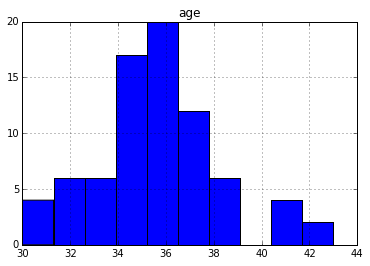

In [24]:
# Subsetting Brooklyn station data and creating histogram of the median ages
BK = stations_med_age[stations_med_age['boro']=='BK']
BK.hist('age')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107e83710>]], dtype=object)

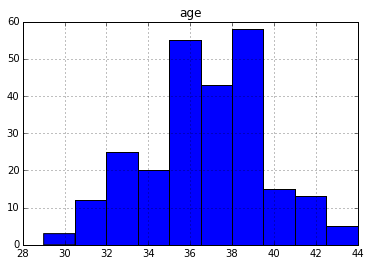

In [25]:
# Subsetting Manhattan station data and creating histogram of the median ages
MH = stations_med_age[stations_med_age['boro']=='MH']
MH.hist('age')